# Robust Gaussian Processes via Relevance Pursuit
This tutorial showcases the robust Gaussian process model and Relevance Pursuit algorithm introduced in the NeurIPS 2024 article ["Robust Gaussian Processes via Relevance Pursuit"](https://arxiv.org/pdf/2410.24222). The method adaptively identifies a sparse set of outlying data points that are corrupted by a mechanism that is not captured by the other components of the model. This is in contrast to many other approaches
to robust regression that non-adaptively apply a heavy-tailed likelihood to all observations, which
can be suboptimal if many observations are of high quality.

## The Extended Likelihood Model
We extend the standard GP observation noise variance $\sigma^2$ with data-point-specific noise variances
$\rho = \{\rho_i\}_{i=1}^n$, so that the $i$-th data point is distributed as
$$
y_i \ | \ x_i ∼ \mathcal{N}(f(x_i), \sigma^2 + \rho_i).
$$
The marginal likelihood optimization of $\rho_i$ gives rise to an automatic mechanism for the detection and weighting of outliers, as the effect of $y_i$ on the estimate of $f$ vanishes as $\rho_i \to \infty$.

## Relevance Pursuit 

### A Sequential Greedy Optimization of $\rho_i$

Without additional structure, inference of the noise variances $\rho_i$ does not yield desirable models, as
the marginal likelihood can be improved by increasing the prior variance $\rho_i$ of any data point where
Eq. (3) is greater than zero, even if that is due to regular (non-outlier) measurement noise. To avoid
this, we constrain the number of non-zero $\rho_i$, that is, 
$$
\|\rho\|_0 = |\{0 < \rho_i\}| \leq k < n.
$$
While this sparsity constraint mitigates over-flexibility, it gives rise to a formidably challenging optimization
problem, as there are a combinatorial number of sparse outlier sets to consider.
For tractability, we iteratively add data points to a set of potential “outliers” by allowing their associated
$\rho_i$ to be nonzero, based on which $\rho_i$, upon its inclusion to the support set $S = \{0 < \rho_i\}$, leads to the maximal increase in the marginal likelihood of the associated Gaussian process (GP) model.
After adding a $\rho_i$ to $S$, all hyper-parameters of GP are jointly optimized,
and carrying out multiple iterations of the sequential greedy algorithm gives rise to a list of models with varying sparsity levels $|S|$.
The algorithm then leverages the Bayesian model selection framework to select the most promising model out of this list of models.

### Automatic Outlier Detection via Bayesian Model Selection

In practice, it is often impossible to set a hard threshold on the number of outliers for a particular data set. For example, a sensor might have a known failure rate, but how many outliers it produces will depend on the specific application of the sensor. Thus, is often more natural to specify a prior distribution $p(S)$ over the number of outliers, rather than fix the number a priori. We leverage the
Bayesian model selection framework to determine the most probable number of outliers in a data- and model-dependent way, aiming to maximize $p(S|D)$. The Relevance Pursuit algorithm then returns the maximum a-posteriori model under the Bayesian model selection framework.




In [ ]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [1]:
import io
import os
import requests

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.relevance_pursuit import (
    forward_relevance_pursuit,
)
from botorch.models.robust_relevance_pursuit_model import (
    RobustRelevancePursuitSingleTaskGP,
)
from botorch.models.transforms import Normalize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from torch import Tensor

SMOKE_TEST = os.environ.get("SMOKE_TEST")

# Twitter Flash Crash 

In [2]:
def get_data_dir() -> str:
    """
    Get the directory of the data, which is in the BoTorch repo.

    Checks if we are in a common part of the BoTorch repository 
    (botorch/botorch or botorch/tutorials) and returns the right path.
    """
    if "DATA_LOCATION" in os.environ.keys():
        return os.environ["DATA_LOCATION"] + "/"
    cwd = os.getcwd()
    folder = os.path.basename(cwd)
    # automated tests run from botorch folder
    if folder == "botorch":  
        return os.path.join(cwd, "tutorials/data/")
    # typical case (running from tutorial folder)
    elif folder == "tutorials":
        return os.path.join(cwd, "data/")
    raise FileNotFoundError("Could not figure out location of the data folder.")


def get_data() -> pd.DataFrame:
    """Gets the Twitter Flash Crash data, first attempting to load it locally, if the 
    current directory is in a local installation of botorch. If this fails, attempts
    to load the data from the BoTorch GitHub repository.

    Original source of the data: https://finance.yahoo.com/quote/%5EDJI/history/
    Applied data processing:
    1) Selected data from 2013-04-23,
    2) Renamed the "Open" column "Price".
    """
    try: 
        data = pd.read_csv(get_data_dir() + "twitter_flash_crash.csv", index_col=0)
    except Exception as e:  # otherwise, try to load the data from the GitHub repository
        url = "https://github.com/pytorch/botorch/tree/main/tutorials/data/twitter_flash_crash.csv"
        response = requests.get(url)
        if response.status_code == 200:
            data = pd.read_csv(response.text, index_col=0)
        else:
            raise FileNotFoundError(
                "Failed to retrieve data from GitHub and encountered exception locally: " + str(e)
            )
            
    data["Time"] = pd.to_datetime(data["Time"])
    return data

In [3]:
data = get_data()

In [4]:
def convert_to_tensor(X):
    return torch.tensor(X.to_numpy().astype(np.float64), dtype=torch.float64).unsqueeze(-1)
    
X = convert_to_tensor(data["Time"])
Y = convert_to_tensor(data["Price"])

## Fitting Standard Gaussian Process

In [5]:
standard_model = SingleTaskGP(X, Y, input_transform=Normalize(d=X.shape[-1]))
standard_mll = ExactMarginalLogLikelihood(model=standard_model, likelihood=standard_model.likelihood)
fit_gpytorch_mll(standard_mll);

## Fitting Robust Gaussian Process via Relevance Pursuit

In [6]:
model = RobustRelevancePursuitSingleTaskGP(
    train_X=X,
    train_Y=Y,
    input_transform=Normalize(d=X.shape[-1]),
    # Setting the mean of exponential prior over number of outliers,
    # to be relatively small to encourage the model to only leverage
    # few additional noise variances. The default prior is 20% of the
    # number of data points. Note that the quality of the predictor
    # doesn't depend in a significant way on this input for this
    # application, unless the prior is set too aggressively.
    prior_mean_of_support=16.0,
)

In [7]:
mll = ExactMarginalLogLikelihood(model=model, likelihood=model.likelihood)
fit_gpytorch_mll(
    mll=mll, 
    # Since we are using a more aggressive prior, we primarily consider
    # a small maximum number of outliers by setting the numbers_of_outliers
    # argument, and use the forward version of Relevance Pursuit, which is
    # particularly efficient for smaller number of outliers.
    # Note however that the default settings, including the backward
    # algorithm and a much coarser set of outlier levels, performs
    # equally well on this data, though it takes more time to optimize.
    # The particular choices here are made to showcase usage modifications.
    numbers_of_outliers=[0, 1, 2, 3, 4, 5, 6, 7, 8],
    # resetting the parameters after every restarts the model fit from 
    # scratch, but can lead to an increase in runtime and, if the joint
    # hyper-parameter optimization problem is non-convex, can lead the 
    # model fit to terminate in a different local minimum of the marginal
    # likelihood.
    reset_parameters=False,
    relevance_pursuit_optimizer=forward_relevance_pursuit,
    optimizer_kwargs={"options": {"maxiter": 1 if SMOKE_TEST else 1024}},
);

## Comparing Predictions

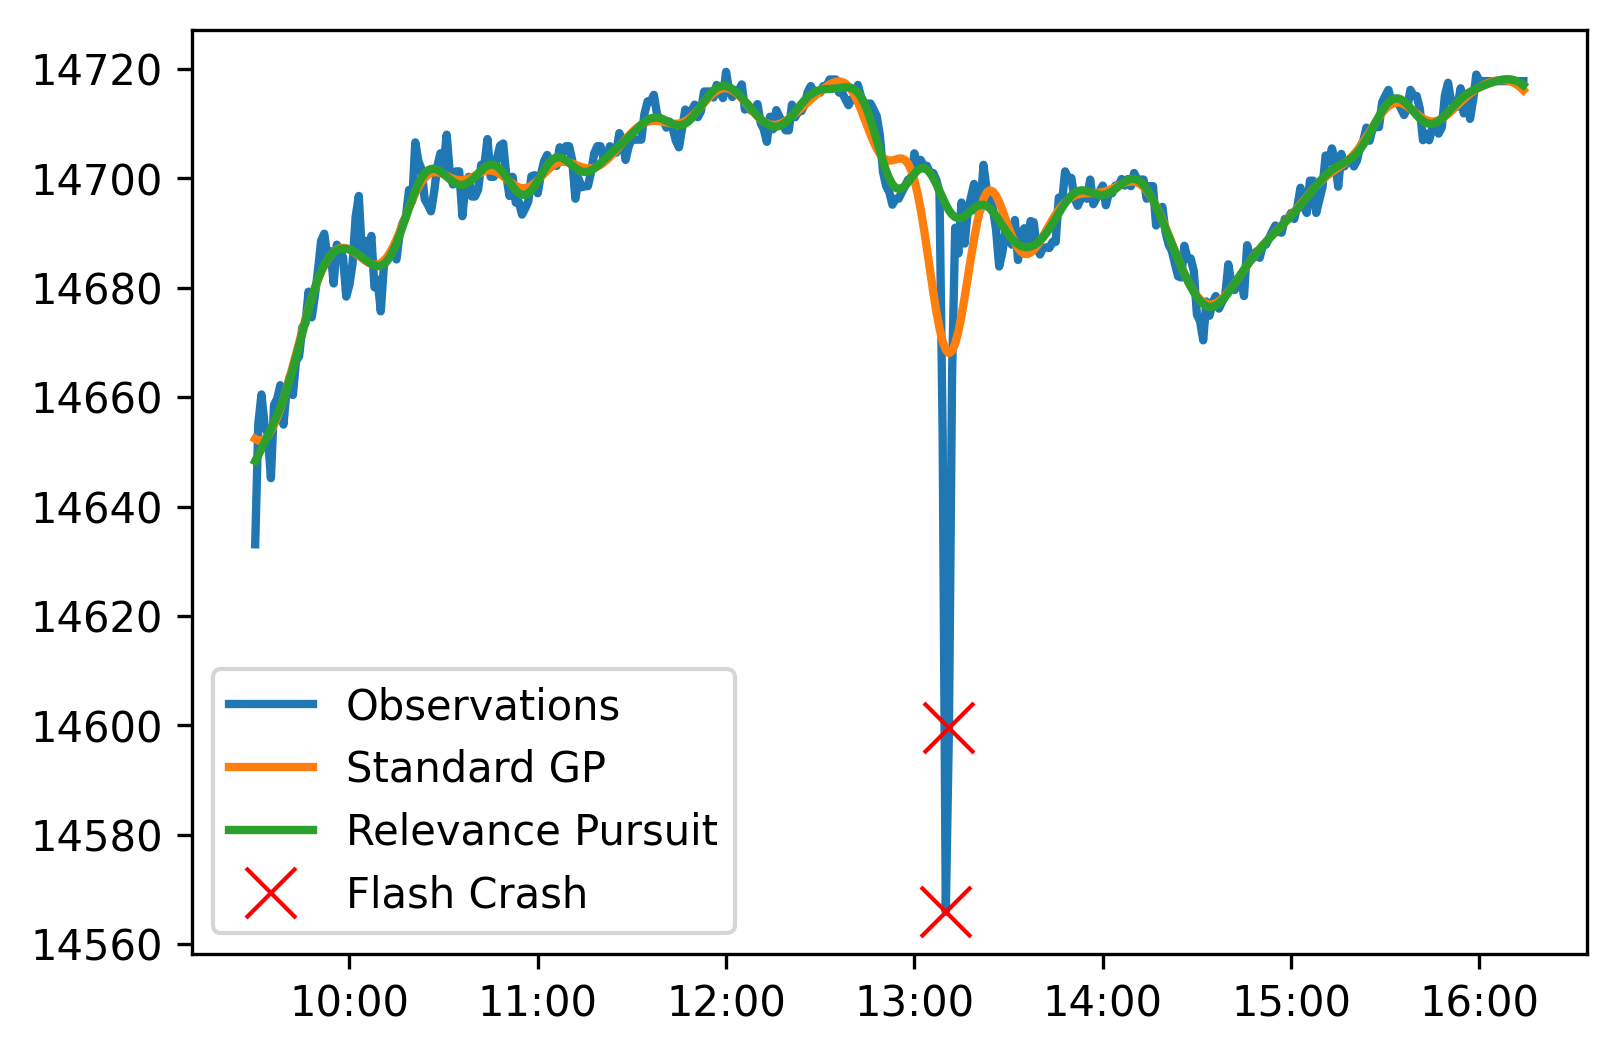

In [8]:
standard_post = standard_model.posterior(X)
Y_pred = standard_post.mean.detach()

rp_post = model.posterior(X)
Y_pred_rp = rp_post.mean.detach()

outlier_indices = [220, 221]
X_plot = data["Time"].to_numpy()
lw = 2.0

# controlling plot
dpi = 300
figsize = (6, 4)
fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
# Set the x-axis to display only hours
hour_formatter = mdates.DateFormatter('%H:%M')  # Show hours and minutes
ax.xaxis.set_major_formatter(hour_formatter)
# set the x-axis tick locations to specific hours (e.g., every 4 hours)
hours_locator = mdates.HourLocator(interval=1)  # Show ticks every hour
ax.xaxis.set_major_locator(hours_locator)

plt.plot(X_plot, Y, label="Observations", lw=lw)
plt.plot(X_plot, Y_pred, label="Standard GP", lw=lw)
plt.plot(X_plot, Y_pred_rp, label="Relevance Pursuit", lw=lw)
plt.plot(X_plot[outlier_indices], Y[outlier_indices], "x", label="Flash Crash", c="red", ms=12)

plt.legend()

## Bayesian Model Comparison
The following plot shows the posterior marginal likelihoods as a function of the support size (i.e. number of outliers), which is used insde the Relevance Pursuit algorithm to automatically optimize the number of additional noise variances that are used to explain any outlying observations.

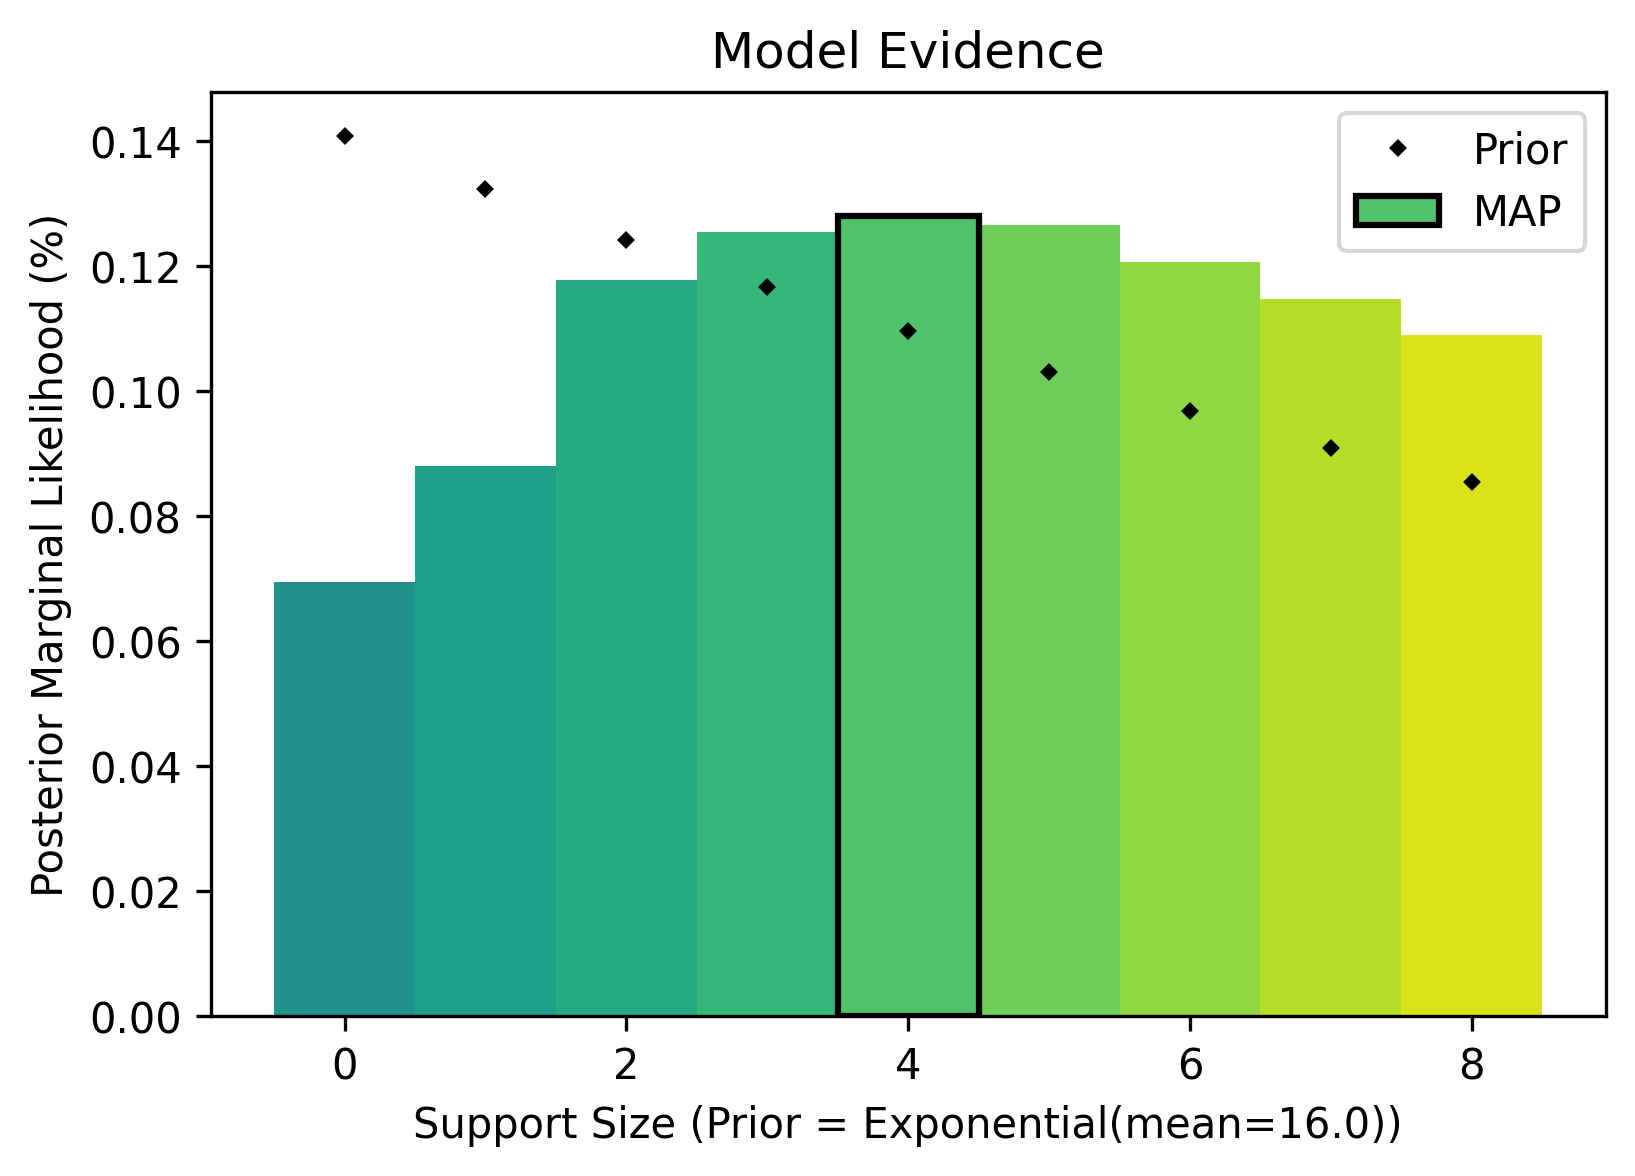

In [9]:
import matplotlib

def bmc_plot(bmc_support_sizes: Tensor, bmc_probabilities: Tensor) -> None:
    cmap = matplotlib.colormaps["viridis"]
    bar_width = 1
    plt.title("Model Evidence")
    for i, ss in enumerate(bmc_support_sizes):
        color = cmap((1 - (len(bmc_support_sizes) - i) / (2 * len(bmc_support_sizes))))
        plt.bar(ss, bmc_probabilities[i], color=color, width=bar_width)

    i = bmc_probabilities.argmax()
    map_color = cmap((1 - (len(bmc_support_sizes) - i) / (2 * len(bmc_support_sizes))))
    plt.bar(
        bmc_support_sizes[i],
        bmc_probabilities[i],
        color=map_color,
        label="MAP",
        edgecolor="black",
        linewidth=1.5,
        width=bar_width,
    )

    support_prior = torch.exp(-bmc_support_sizes / model.prior_mean_of_support)
    support_prior = support_prior / support_prior.sum()
    plt.plot(bmc_support_sizes, support_prior, "D", color="black", label="Prior", ms=2)
    # plt.plot(bmc_support_sizes, support_prior, color="black", label="Prior")
    # plt.bar(support_size, bmc_probabilities)
    plt.xlabel(f"Support Size (Prior = Exponential(mean={model.prior_mean_of_support:.1f}))")
    plt.ylabel("Posterior Marginal Likelihood (%)")
    plt.legend(loc="upper right")

figsize = (6, 4)
fig = plt.figure(dpi=dpi, figsize=figsize)
bmc_plot(model.bmc_support_sizes.detach(), model.bmc_probabilities.detach())

# Synthetic Example

The following highlights the robust model's performance on a particularly challenging example where outliers are hidden within the target function's range.

In [10]:
# one-dimensional example
# function definition
f = lambda X: torch.sin(2 * torch.pi * (2 * X)).sum(dim=-1, keepdim=True)

# Seeds that lead to interesting outlier distributions and model behavior:
# NOTE that the method works regardless of the seed, the choices here
# are mainly provided to highlight non-trivial datasets and interesting
# model and algorithm behavior.
# most chaotic model trace:
torch.manual_seed(17)  
# interesting intermediate models with small lengthscale:
# torch.manual_seed(18)  
# outliers well distributed in x:
# torch.manual_seed(7)
# torch.manual_seed(10)
# torch.manual_seed(24)

n = 32
dtype = torch.double
num_outliers = 4
X = torch.rand(n, 1, dtype=dtype)
F = f(X)
sigma = 2e-2
Y = F + torch.randn_like(F) * sigma
# add outliers
Y[-num_outliers:] = 2 * torch.rand(num_outliers, 1) - 1

In [11]:
from gpytorch.means import ZeroMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.utils.constraints import NonTransformedInterval

# The definition of "outliers" depends on the model capacity, so what is an outlier
# w.r.t. a simple model might not be an outlier w.r.t. a complex model.
# For this reason, it is necessary to bound the lengthscale of the GP from below
# as otherwise arbitrarily complex outlier deviations can be modeled well by the GP,
# if the data is not sampled finely enough.
min_lengthscale = 0.05
lengthscale_constraint = NonTransformedInterval(
    min_lengthscale, torch.inf, initial_value=0.2
)

covar_module = ScaleKernel(
    RBFKernel(ard_num_dims=X.shape[-1], lengthscale_constraint=lengthscale_constraint),
    outputscale_constraint=NonTransformedInterval(0.01, 10.0, initial_value=0.1),
)

model = RobustRelevancePursuitSingleTaskGP(
    train_X=X,
    train_Y=Y,
    input_transform=Normalize(d=X.shape[-1]),
    cache_model_trace=True,  # necessary to plot the model trace after optimization
    mean_module=ZeroMean(),
    covar_module=covar_module,
)

In [12]:
mll = ExactMarginalLogLikelihood(model=model, likelihood=model.likelihood)
# The backward algorithm is used by default.
fit_gpytorch_mll(
    mll=mll,
    # This is the default set of support sizes considered by the algorithm:
    # "numbers_of_outliers": list(range(n + 1)),
    # The following is faster. The step at 16 helps the backward algorithm by
    # providing an intermediate step between 32 and the smaller support
    # sizes, a good trade-off between best optimization results and run time.
    # The default settings incorporate a similar strategy by considering support
    # sizes at 0%, 5%, 10%, 15%, 20%, 30%, 40%, 50%, 75%, and 100% of the number
    # of training data points.
    numbers_of_outliers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 16],
    optimizer_kwargs={"options": {"maxiter": 1 if SMOKE_TEST else 1024}},
);

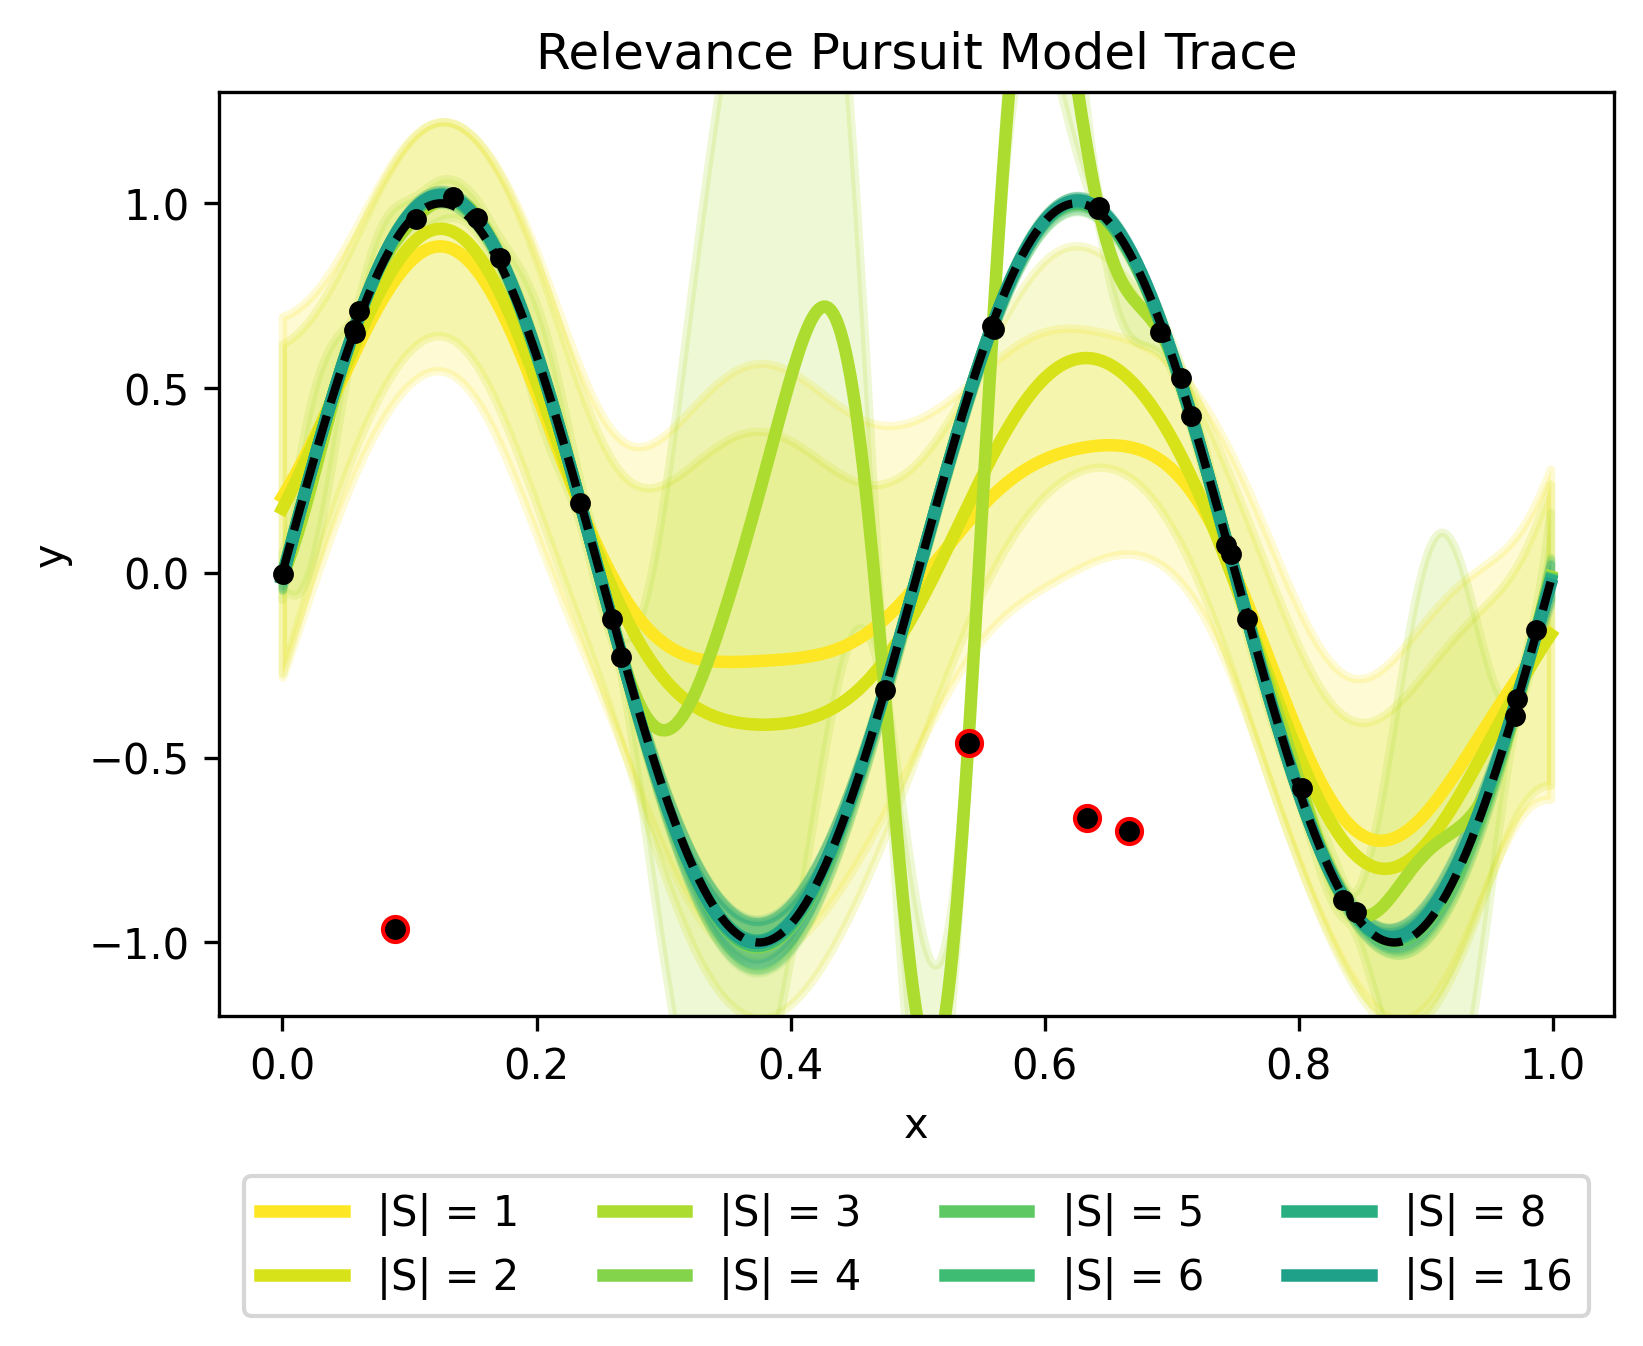

In [13]:
cmap = matplotlib.colormaps["viridis"]

figsize = (6, 4)
plt.figure(dpi=300, figsize=figsize)
plt.title("Relevance Pursuit Model Trace")

lw = 3
trace_dict = {len(model_i.likelihood.noise_covar.support): model_i for model_i in model.model_trace}
plot_support = [1, 2, 3, 4, 5, 6, 8, 16]
plot_trace = {i: trace_dict[i] for i in plot_support if i in trace_dict}

num_plot = 512
X_plot = torch.arange(0, 1, 1 / num_plot).unsqueeze(-1)

for i, (support_size, model_i) in enumerate(plot_trace.items()):
    mean = model_i.posterior(X_plot).mean.detach().squeeze(-1)
    std = model_i.posterior(X_plot).variance.sqrt().detach().squeeze(-1)
    color = cmap((1 - i / (2 * len(plot_trace))))
    plt.plot(
        X_plot,
        mean,
        label=f"|S| = {support_size}",
        color=color,
        lw=lw,
    )
    nsigma = 2
    plt.fill_between(
        X_plot.squeeze(-1),
        mean - nsigma * std,
        mean + nsigma * std,
        alpha=0.2,
        color=color,
        lw=2,
    )

plt.plot(
    X[-num_outliers:],
    Y[-num_outliers:],
    "o",
    color="red",
    ms=6,  # label="Outliers"
)
plt.plot(X, Y, "o", color="black", ms=4)  # label="Observations"
plt.plot(
    X_plot, f(X_plot), linestyle="--", color="black", linewidth=2
)  # label="Truth"

# plt.ylim(-1.5, 1.25)
plt.ylim(-1.2, 1.3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.15))

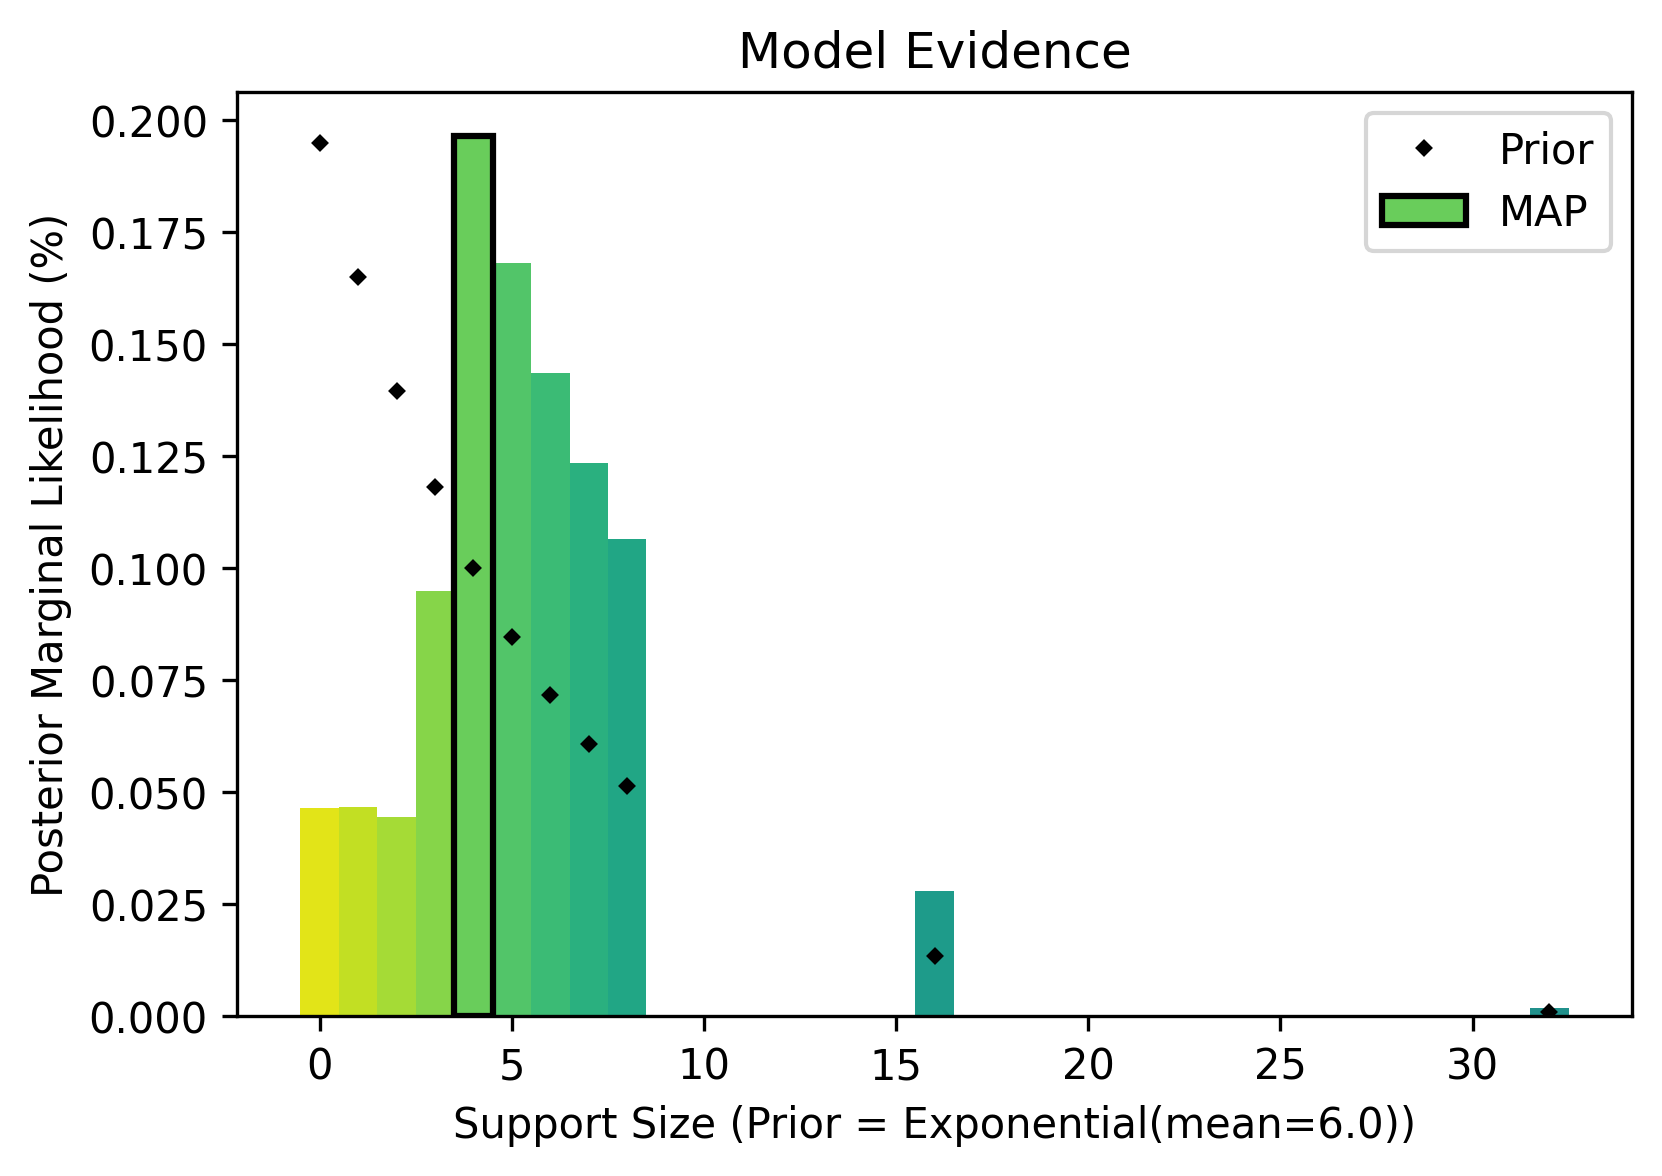

In [14]:
plt.figure(dpi=dpi, figsize=figsize)
bmc_plot(model.bmc_support_sizes.detach(), model.bmc_probabilities.detach())

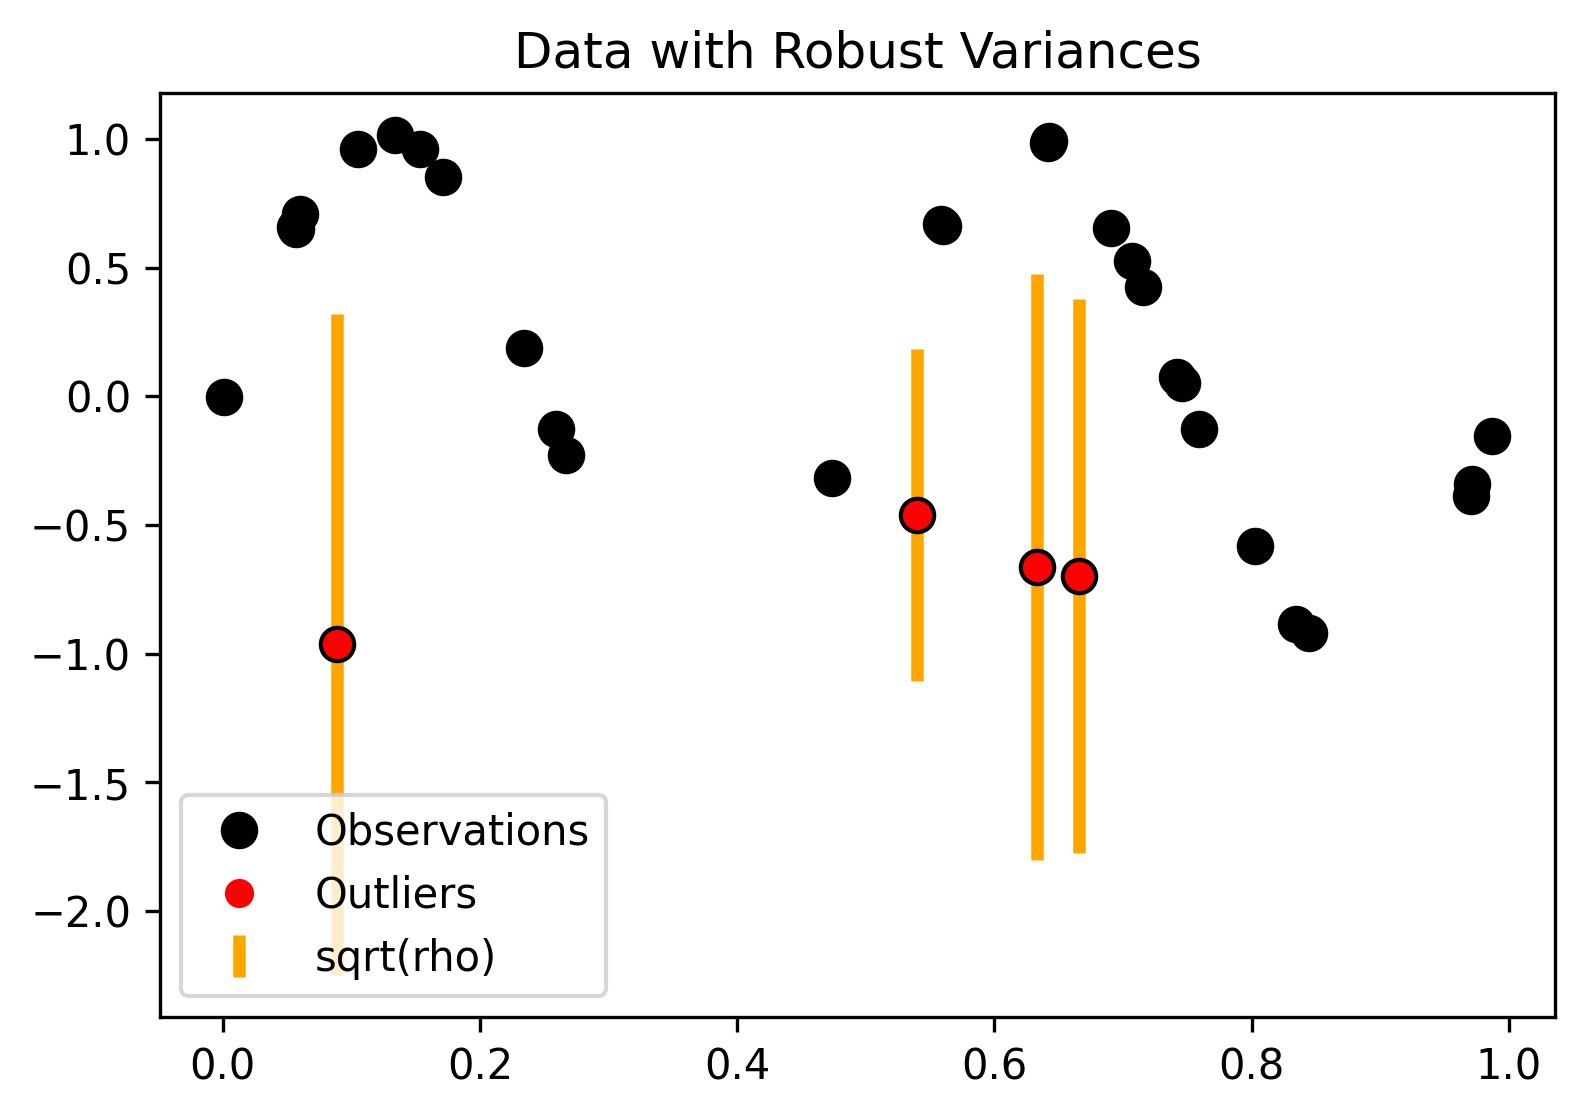

In [15]:
# the following plot shows the original dataset, with the inferred
# robust standard deviations sqrt(rho) overlayed. Notably, the inferred 
# noise variances are particularly large for the outlying data points.
rho = model.likelihood.noise_covar.rho.detach()
plt.figure(dpi=dpi, figsize=figsize)
plt.title("Data with Robust Variances")
plt.errorbar(
    X,
    Y.squeeze(-1),
    color="orange",
    marker="None",
    ms=4,
    linewidth=3,
    yerr=rho.sqrt(),
    linestyle="None",
    label="sqrt(rho)",
)
plt.plot(X, Y.squeeze(-1), "o", color="black", ms=8, label="Observations")
plt.plot(
    X[-num_outliers:],
    Y[-num_outliers:],
    "o",
    color="red",
    ms=6,
    label="Outliers",
)
plt.legend()